In [117]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob

from line import Line


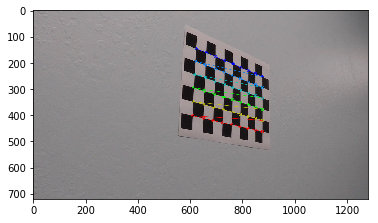

In [16]:
# finding chessboard corners

# prepare object points
nx = 9
ny = 6

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

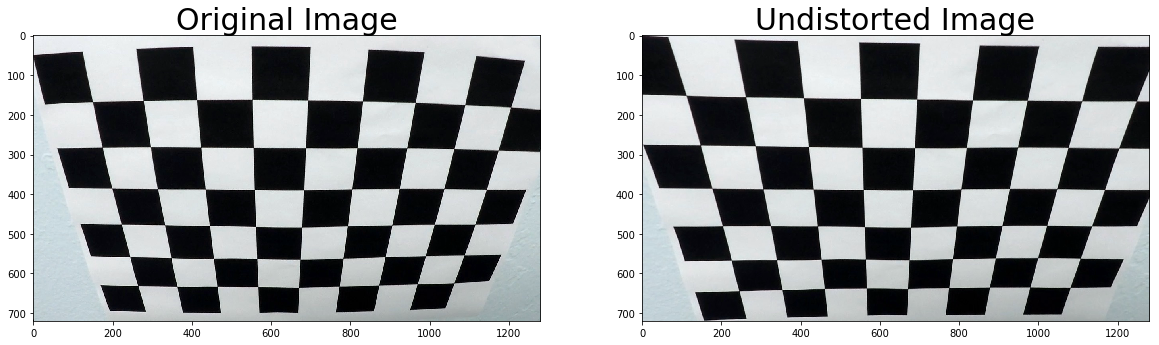

In [19]:
# perform calibration

def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst, mtx, dist

# test on an image
fname = './camera_cal/calibration2.jpg'
img = cv2.imread(fname)

dst, mtx, dist = cal_undistort(img, objpoints, imgpoints)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

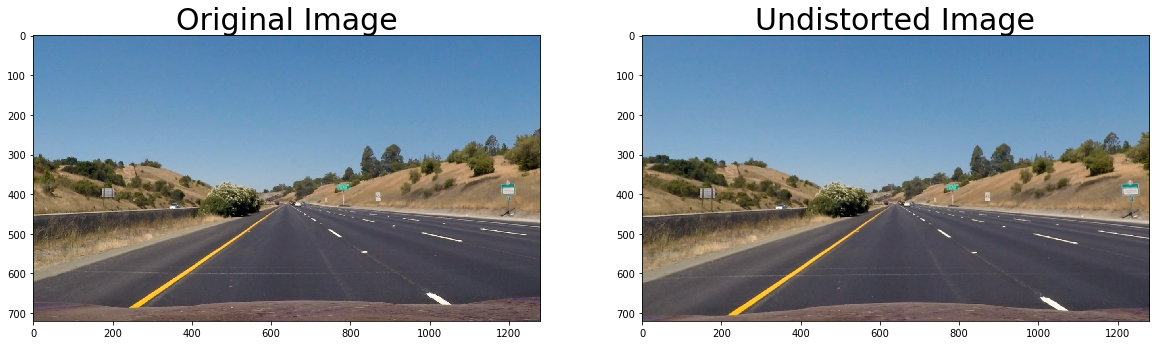

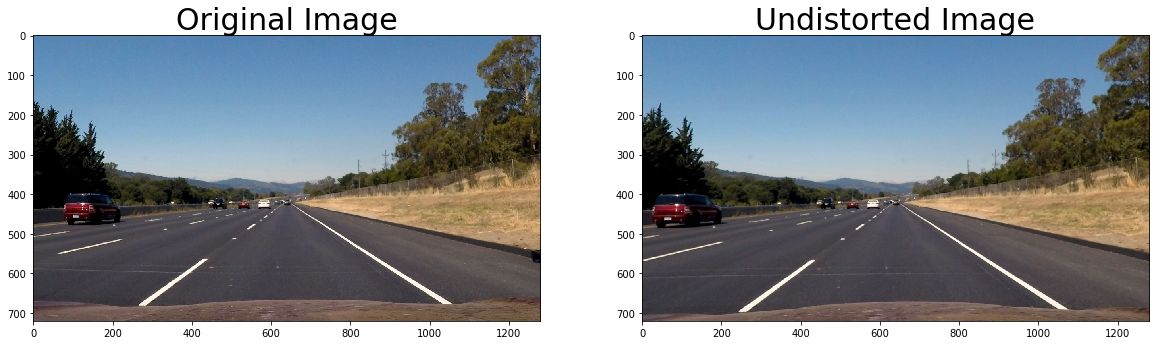

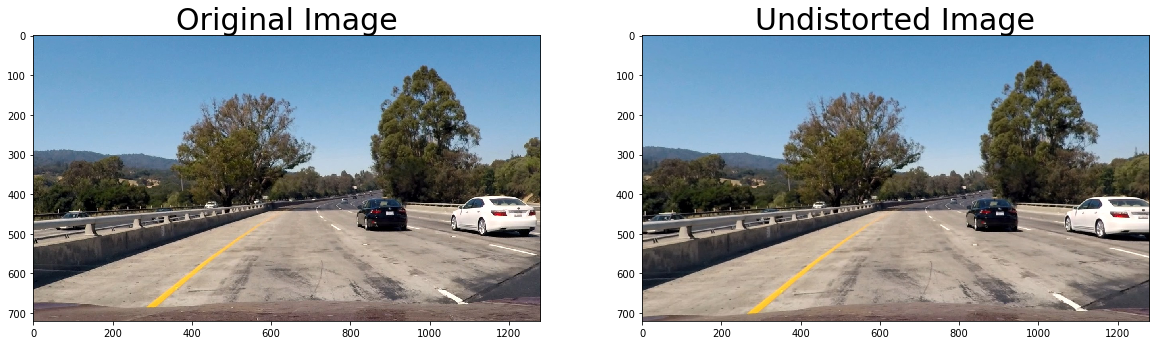

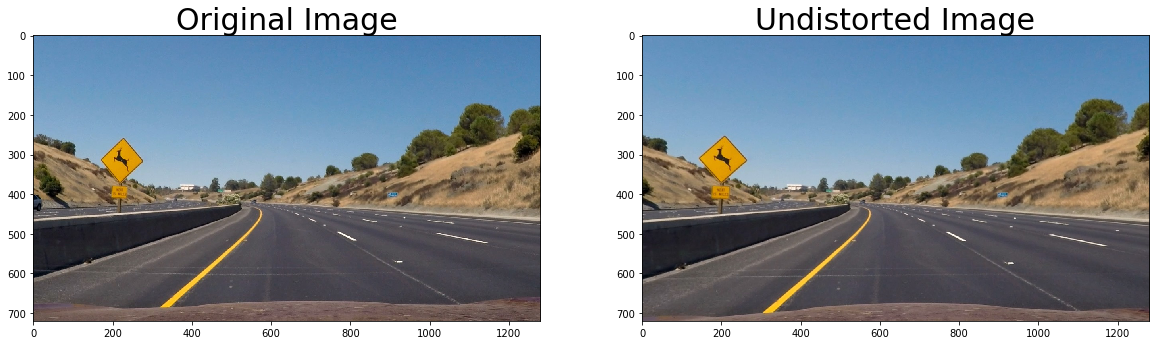

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


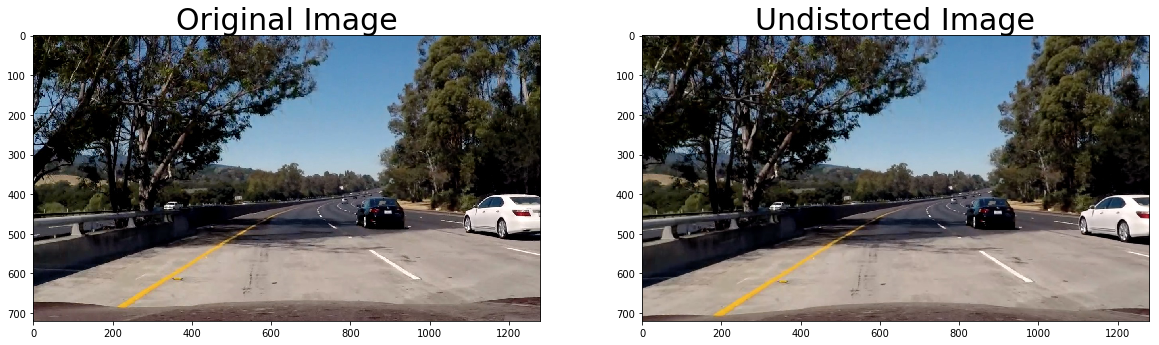

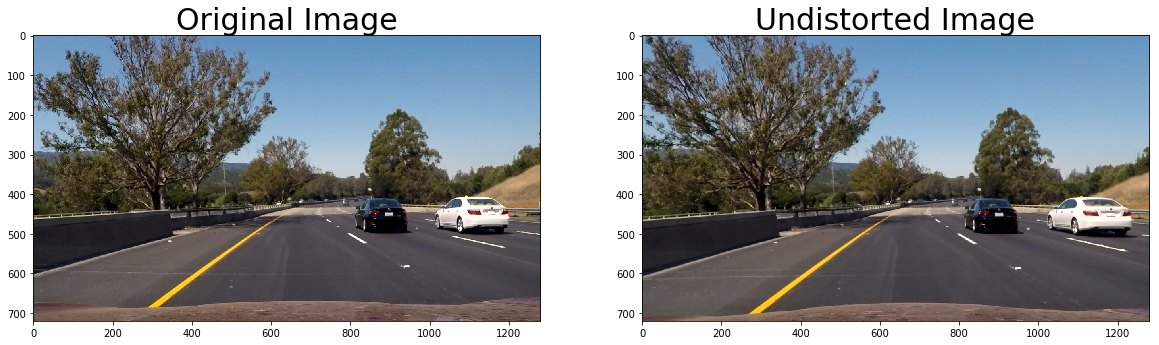

In [30]:
# test undistortions
def test_undistortion(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
    ax2.set_title('Undistorted Image', fontsize=30)
    plt.show()

images = glob.glob('./test_images/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    test_undistortion(img)

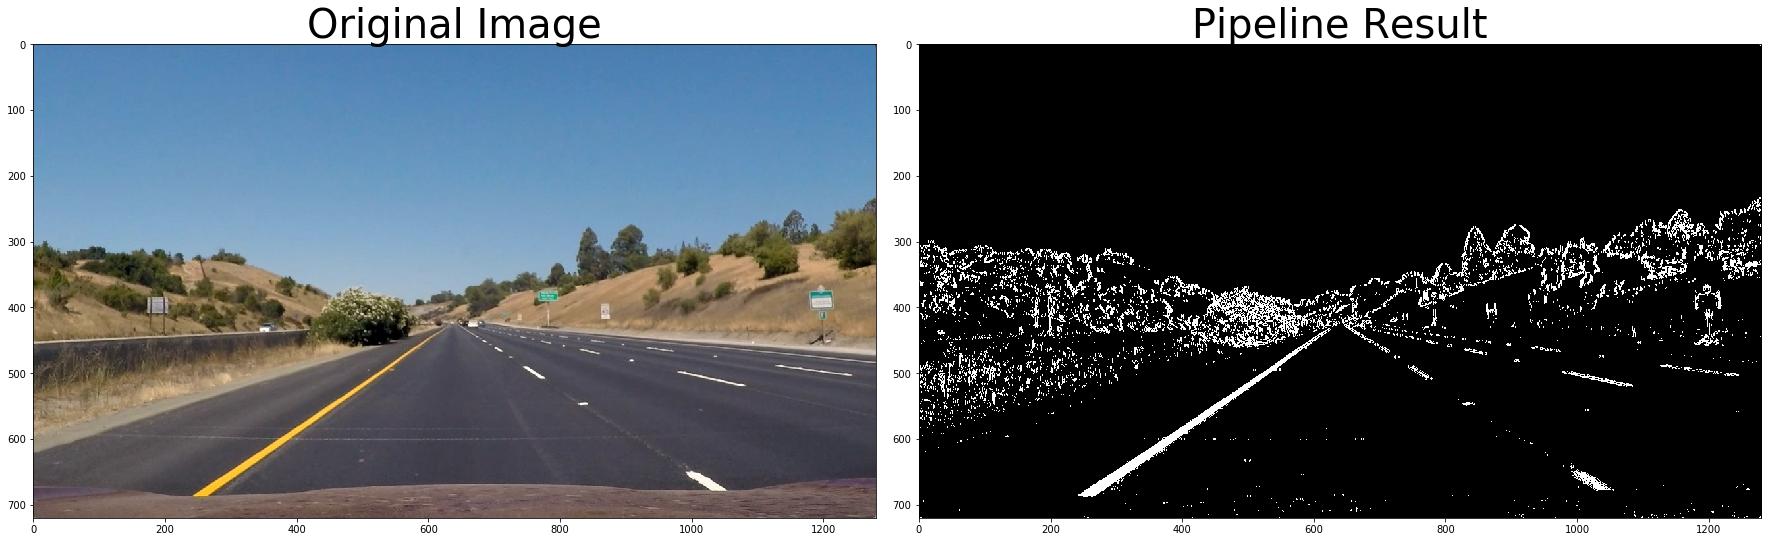

In [101]:
# apply transforms and gradients

def apply_thresholding(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    
    # combined binary
    combined = np.zeros_like(sxbinary)
    combined[((sxbinary == 1) | (s_binary == 1))] = 1

    return combined
    #color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    #return color_binary

fname = './test_images/straight_lines1.jpg'
img = cv2.imread(fname)
result = apply_thresholding(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

(1280, 720)
(1280, 720)


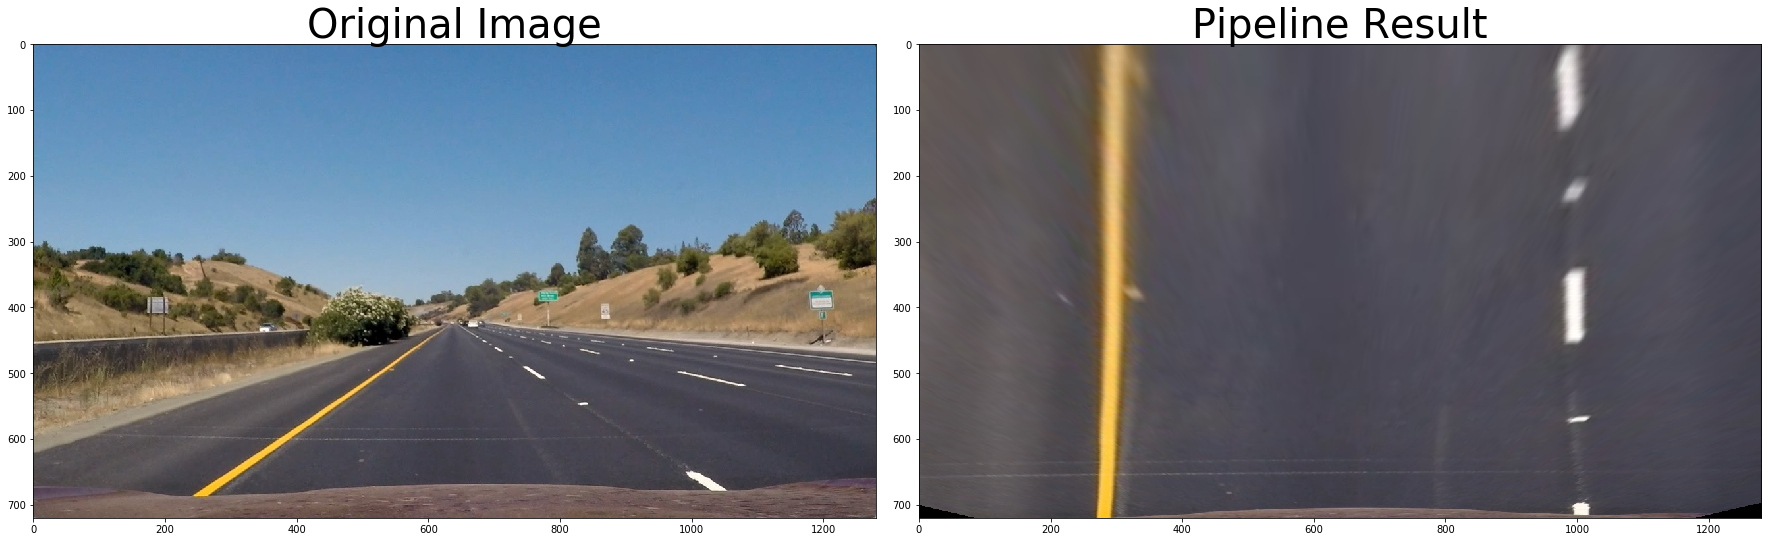

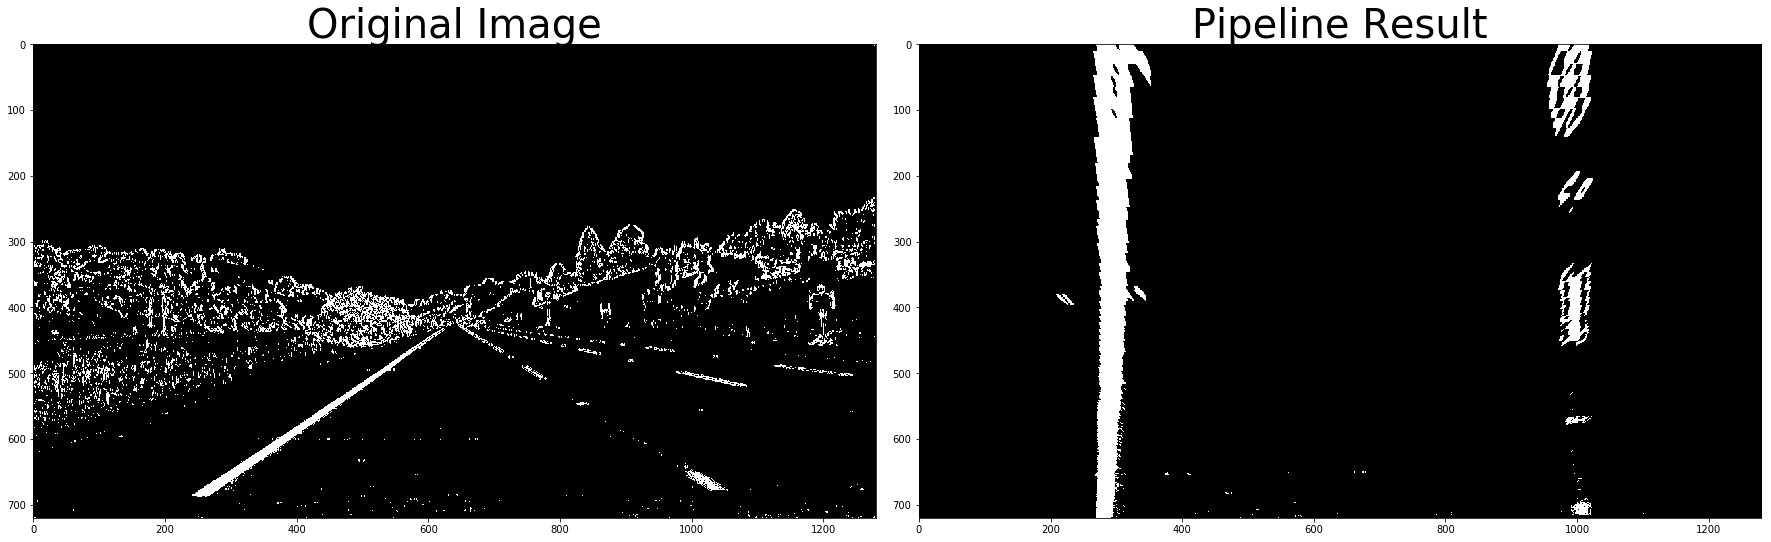

In [115]:
# warp to "birds-eye view"
def undistort_and_warp(img, reverse=False):
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    img_size = (img.shape[1], img.shape[0])
    # ul - ur - br - bl
    src = np.float32(
        [[(img_size[0] / 2)-58, (img_size[1] / 2)+100],
        [(img_size[0] / 2)+60, (img_size[1] / 2)+100],
        [(img_size[0]) - 230, img_size[1] - 15],
        [250, img_size[1] - 15]])
    
    dst = np.float32(
        [[300, 0],
        [img_size[0]-300, 0],
        [img_size[0]-300, img_size[1]],
        [300, img_size[1]]])
    
    print(img_size)
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, (img_size))
    
    return warped

# test
fname = './test_images/straight_lines1.jpg'
img = mpimg.imread(fname)
result = undistort_and_warp(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# apply to bw thresholded
bwthresh = apply_thresholding(img)
warped_binary = undistort_and_warp(bwthresh)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(bwthresh, cmap='gray')
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped_binary, cmap='gray')
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

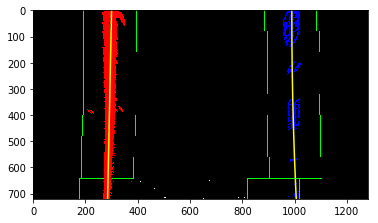

In [116]:
# find lane lines

#histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
#plt.plot(histogram)

def find_lane_lines(warped_binary):
    histogram = np.sum(warped_binary[warped_binary.shape[0]//2:,:], axis=0)
    
    # to visualize results
    out_img = np.dstack((warped_binary, warped_binary, warped_binary))*255
    
    # find the peak of left and right side
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[:midpoint]) + midpoint
    
    # sliding windows
    nwindows = 9
    window_height = np.int(warped_binary.shape[0]/nwindows)
    
    # identify positions of all nonzero pixels
    nonzero = warped_binary.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # current positions to update for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # margin to search and minpix to find
    margin = 100
    minpix = 50
    
    # lists to receive lane pixels
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_binary.shape[0] - (window+1)*window_height
        win_y_high = warped_binary.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
find_lane_lines(warped_binary)

In [ ]:
# curve detection

In [ ]:
# main pipeline
def main_pipeline(image):